<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/llamaindex/multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval for Climate Change APP
Reference: [Notebook link](https://github.com/run-llama/llama_index/blob/main/docs/examples/multi_modal/multi_modal_retrieval.ipynb) from LlamaIndex & [Blog post](https://medium.com/gitconnected/multimodal-retrieval-with-text-embedding-and-clip-image-embedding-for-backyard-birds-599f19057a70) from Wenqi Glantz.



Let's build a Multi-Modal retrieval system using LlamaIndex.

1. OpenAI CLIP model `ViT-B/32` for image embeddings.
2. `embed-englishv3` for text embeddings. (cohere embedding) [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)
3. `Aya Model` as LLM for text response synthesizing. (NOT AVAILABLE FOR COHERE YET USING COMMAND Model)



Steps:
1. Upload Climate PDF Files.
2. Index the text using `embed-englishv3` embeddings.
3. Index the images using OpenAI [CLIP](https://github.com/openai/CLIP) embeddings.
5. Both the text and image embeddings are stored as separate collection in [Qdrant](https://qdrant.tech/).
4. During query, retrieve both text and images.

**CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs**

In [35]:
%%capture
!pip install llama_index ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
!pip install matplotlib scikit-image
!pip install -U qdrant_client
!pip install PyPDF2 Cohere llama_index
!pip install fastapi
!pip install llama_index[schema]

## Load Multi-Modal datasets including texts and images from PDF

Parse PDF articles and save into local folder

In [36]:
pdf_sources = {
    "Climate Change Anxiety": {
        "pdf_name": "Climatechangeanxiety.pdf",
        "url": "https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196(21)00278-3/fulltext"
    },
    "Rexdale SNAP Action Plan": {
        "pdf_name": "Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2.pdf",
        "url": "https://trca.ca/conservation/sustainable-neighbourhoods/snap-neighbourhood-projects/rexdale-snap/"
    }
}

In [37]:
from pathlib import Path
import PyPDF2

# Define the file paths for the PDFs
pdf_paths = {
    "Climatechangeanxiety.pdf": "/content/Climatechangeanxiety.pdf",
    "Rexdale_SNAP-Action-Plan-Report-11-20-23-FA-2-2.pdf": "/content/Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2-2.pdf"
}

data_path = Path("data_pdfs")

if not data_path.exists():
    data_path.mkdir()

for title, pdf_file_path in pdf_paths.items():
    try:
        with open(pdf_file_path, "rb") as file:
            reader = PyPDF2.PdfReader(file)
            num_pages = len(reader.pages)

            pdf_text = ""
            for page in range(num_pages):
                pdf_text += reader.pages[page].extract_text()

            # Prepare the document metadata including the PDF source information
            pdf_info = next((info for name, info in pdf_sources.items() if info["pdf_name"] == title), None)
            pdf_metadata = {
                "pdf_name": pdf_info["pdf_name"] if pdf_info else "Unknown",
                "url": pdf_info["url"] if pdf_info else "Unknown"
            }

            # Include the PDF metadata at the beginning of the text
            pdf_text = f"PDF Name: {pdf_metadata['pdf_name']}\nPDF URL: {pdf_metadata['url']}\n\n{pdf_text}"

            # Save the document with the metadata included
            with open(data_path / f"{title[:-4]}.txt", "w") as fp:
                fp.write(pdf_text)

    except FileNotFoundError:
        print(f"File not found: {pdf_file_path}")


In [ ]:
#pwd

In [ ]:
#!rm -rf /content/data_pdfs/

In [ ]:
#!rm -rf /content/images_pdfs/

In [38]:
import os
import cohere
from google.colab import userdata

COHERE_API_KEY = userdata.get('COHERE_API_KEY')

## Build text index for Vector Store and define the text query engine

In [39]:
%%capture
!pip install transformers llama-index llama-index-llms-cohere llama-index-embeddings-huggingface
!pip install llama-index-vector-stores-postgres llama-index-vector-stores-qdrant
!pip install -U qdrant_client fastembed llama-index-vector-stores-chroma
!pip install llama-index-embeddings-cohere

In [40]:
import qdrant_client
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex, StorageContext, Settings
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.llms.cohere import Cohere
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.cohere import CohereEmbedding

# Configure the global Settings according to the documentation
Settings.llm = Cohere(model = 'command-r-plus', temperature=0.1, api_key=COHERE_API_KEY)
Settings.embed_model = CohereEmbedding(cohere_api_key=COHERE_API_KEY,model_name="embed-multilingual-v3.0")
#Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

# create QdrantClient with the location set to ":memory:", which means the vector db will be stored in memory
text_client = qdrant_client.QdrantClient(location=":memory:")

# load Text documents from the data_pdfs directory
text_documents = SimpleDirectoryReader("./data_pdfs").load_data()

# Create QdrantVectorStore using QdrantClient and the collection name "climate_text"
text_vector_store = QdrantVectorStore(client=text_client, collection_name="climate_text")

# Create StorageContext object using the QdrantVectorStore
storage_context = StorageContext.from_defaults(vector_store=text_vector_store)

# Since Settings are now global, you might not need to pass service_context explicitly
# However, adjustments might be needed depending on how VectorStoreIndex interacts with Settings
climate_text_index = VectorStoreIndex.from_documents(
    text_documents,
    storage_context=storage_context
    # The service_context parameter might be omitted if Settings are automatically applied globally
)

# Define the text query engine
text_query_engine = climate_text_index.as_query_engine()

In [41]:
len(text_documents)

2

## Build image index for vector store using OpenAI CLIP embeddings

### Load and initialize CLIP model

In [42]:
import torch
import clip
import numpy as np

model, preprocess = clip.load("ViT-B/32")
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


### Download and store images from PDF pages

In [43]:
pip install PyMuPDF

In [15]:
## only fun if images are already loaded
#rm -rf images_pdfs

In [24]:
from pathlib import Path
import fitz  # PyMuPDF library for extracting images from PDFs

image_path = Path("images_pdfs")
image_uuid = 0
image_metadata_dict = {}
MAX_IMAGES_PER_PDF = 40

pdf_titles = [
    "Climatechangeanxiety.pdf",
    "Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2-2.pdf"
]

# create folder for images only if not image_path.exists():
Path.mkdir(image_path)

# Download images for PDF files
for title in pdf_titles:
    images_per_pdf = 0
    print(title)
    try:
        with fitz.open(title) as doc:
            for page_num in range(len(doc)):
                page = doc[page_num]
                images = page.get_images()
                for img in images:
                    xref = img[0]
                    base_image = doc.extract_image(xref)
                    image_uuid += 1
                    image_file_name = f"{title[:-4]}_{image_uuid}.{base_image['ext']}"
                    image_metadata_dict[image_uuid] = {
                        "filename": image_file_name,
                        "img_path": "./" + str(image_path / image_file_name),
                        "pdf_title": title,
                    }
                    with open(image_path / image_file_name, "wb") as f:
                        f.write(base_image["image"])
                    images_per_pdf += 1
                    if images_per_pdf > MAX_IMAGES_PER_PDF:
                        break
    except Exception as e:
        print(f"Error processing {title}: {str(e)}")
        continue

Climatechangeanxiety.pdf
Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2-2.pdf


### Show downloaded Images from pdf

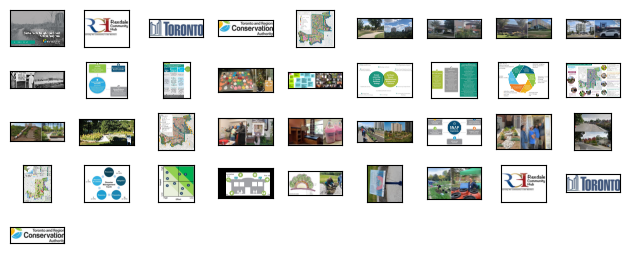

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(9, 9, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 79:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

### Generate Clip embedding for each each image

In [26]:
# set the device to use for the CLIP model, either CUDA (GPU) or CPU, depending on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model, preprocess = clip.load("ViT-B/32", device=device)
print(clip.available_models())

# img_emb_dict stores image embeddings for each image
img_emb_dict = {}
with torch.no_grad():

    # iterate over the image metadata dictionary and extracts image embeddings for each image
    for image_id in image_metadata_dict:
        img_file_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 2
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )

            # extract image features using the CLIP model's encode_image function
            image_features = model.encode_image(image)

            # store the image features in the image embedding dictionary
            img_emb_dict[image_id] = image_features

cpu
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [45]:
len(img_emb_dict) #37 image so 37 img emb

37

In [46]:
image_id = 1  # replace with the ID of the image you're interested in
print(image_metadata_dict[image_id])

{'filename': 'Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2-2_1.jpeg', 'img_path': './images_pdfs/Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2-2_1.jpeg', 'pdf_title': 'Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2-2.pdf'}


\### Build a separate CLIP image embedding index under a differnt collection `PDF_img`

In [29]:
from llama_index.core.schema import ImageDocument

# create a list of ImageDocument objects, one for each image in the dataset
img_documents = []
for image_filename in image_metadata_dict:
    # the img_emb_dict dictionary contains the image embeddings
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]
        #print(filepath)

        # create an ImageDocument for each image
        newImgDoc = ImageDocument(
            text=filename, metadata={"filepath": filepath}
        )

        # set image embedding on the ImageDocument
        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

# create QdrantVectorStore, with collection name "pdf_img"
image_vector_store = QdrantVectorStore(
    client=text_client, collection_name="pdf_img"
)

# define storage context
storage_context = StorageContext.from_defaults(vector_store=image_vector_store)

# define image index
image_index = VectorStoreIndex.from_documents(
    img_documents,
    storage_context=storage_context
)

### Function for image query

- `retrieve_results_from_image_index` takes a text query as input and returns the most similar image from the vector store.
- `plot_image_retrieval_results` takes a list of image retrieval results and creates a new figure.
- `image_query` is a wrapper function to call the two functions above.

In [47]:
from llama_index.core.vector_stores import VectorStoreQuery


def retrieve_results_from_image_index(query):
    """ take a text query as input and return the most similar image from the vector store """

    # first tokenize the text query and convert it to a tensor
    text = clip.tokenize(query).to(device)

    # encode the text tensor using the CLIP model to produce a query embedding
    query_embedding = model.encode_text(text).tolist()[0]

    # create a VectorStoreQuery
    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1, # returns 1 image
        mode="default",
    )

    # execute the query against the image vector store
    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results


In [48]:
def plot_image_retrieve_results(image_retrieval_results):
    """ take a list of image retrieval results and create a new figure"""

    plt.figure(figsize=(16, 5))

    img_cnt = 0

    # iterate over the image retrieval results, and for each result, display the corresponding image and its score in a subplot.
    # The title of the subplot is the score of the image, formatted to four decimal places.

    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

In [49]:
def image_query(query):
    image_retrieval_results = retrieve_results_from_image_index(query)
    plot_image_retrieve_results(image_retrieval_results)

## TEST 1 Get MultiModal retrieval results (both text and images) for some example queries

Text retrieval results: 
While respondents across all countries reported a high level of worry about climate change, those in Portugal expressed the highest level of worry among the countries surveyed.


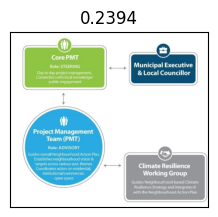

In [50]:
# Climatechangeanxiety
query1 = "Which country is worrying the most about climate change?"
# generate image retrieval results
image_query(query1)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query1)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
The Rexdale SNAP Action Plan is a strategy for improving the sustainability and resilience of the Rexdale neighbourhood in Toronto. It focuses on four key action areas:
1. Open Space Revitalization and Green Infrastructure
2. Boosting the Neighbourhood's Circular and Sharing Economy
3. Retrofits for Sustainable Housing
4. Transformation of Streets and Intersections

The plan also includes a High-Level Climate Resilience Strategy for Rexdale, which addresses climate trends, vulnerabilities, and key opportunities for adaptation.


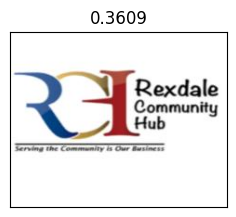

In [51]:
# Rexdale action plans
query2 = "What is rexdale action plans?"
# generate image retrieval results
image_query(query2)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query2)
print("Text retrieval results: \n" + str(text_retrieval_results))